# Modeling Engel outcomes (Multiclass) using clinical data

## Import data

In [215]:
import pandas as pd

# Read dataframe from the pickle format
wide_df = pd.read_pickle("../../data/processed/preprocessed_df.pkl")

## Select features

'sex_gender': 0 represents female and 1 represents male

'age': Age in years

'eeg': number of EEGs per patient

'engel_outcomes': number of Engel outcomes per patient

'mri': number of MRIs per patient

'neuroanatomical_labeling': number of Neuroanatomical labeling per patient

...

In [216]:
# Selecting patients who only went through 1 surgery
wide_df = wide_df[wide_df["surgical_information"]==1]

X = wide_df[["sex_gender", "age", "eeg", "engel_outcomes", "mri", "phys_findings", "age_of_onset", "eo_yrs_postsurg",
             "neuroanatomical_labeling", "neuropsychological_testing", "surg_stage", "neuro_findings", "eo_year_surg",
             "surgical_information", "resect_procedure___1", "resect_procedure___2", "resect_procedure___3",
             "resect_procedure___4", "resect_procedure___5", "resect_procedure___6", "resect_procedure___7",
             "resect_procedure___8", "resect_procedure___9", "resect_procedure___10", "resect_procedure___11",
             "resect_procedure___12", "resect_procedure___14", "resect_procedure___15"]]

y = wide_df["surg_engel"]

# Turns the outcome variable from range [1,4] to [0,3]
y = y - 1

## Correlation matrix

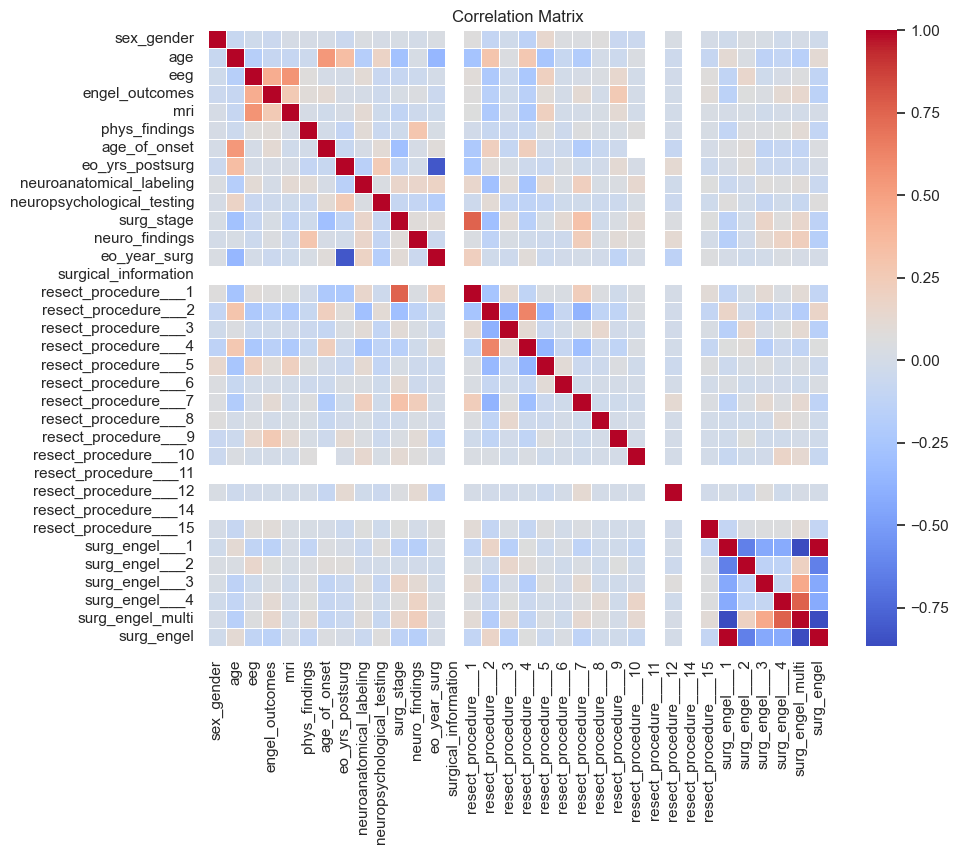

In [217]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

engel = wide_df[['surg_engel___1', 'surg_engel___2', 'surg_engel___3', 'surg_engel___4', 'surg_engel']]
engel = engel.rename(columns={'surg_engel': 'surg_engel_multi'})
y2 = y==0
engel = pd.concat([engel, y2], axis=1)

# Calculate the correlation matrix
correlation_matrix = pd.concat([X, engel], axis=1).corr()

# Create a heatmap using seaborn
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [218]:
# Create a boolean mask for rows with different values
mask = engel["surg_engel"] != engel["surg_engel___1"]

# Filter the DataFrame based on the mask
rows_with_different_values = engel[mask]

# Display rows with different values
print("\nRows with different values:")
print(rows_with_different_values)


Rows with different values:
Empty DataFrame
Columns: [surg_engel___1, surg_engel___2, surg_engel___3, surg_engel___4, surg_engel_multi, surg_engel]
Index: []


## Split data into train/test

In [219]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

Here, we perform SMOTE (Synthetic Minority Over-sampling Technique) to handle the Class Imbalance

In [158]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pandas as pd

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='median')

# Impute missing values in X_train
X_train_imputed = imputer.fit_transform(X_train)

# Convert back to DataFrame if X_train was a DataFrame
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)

# Now apply SMOTE
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train_imputed, y_train)

X_test_imputed = imputer.transform(X_test)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

## 5-fold cross-validation

By splitting your data into multiple training and validation sets (like in k-fold cross-validation), you can assess the consistency of your model’s performance. Fluctuations in performance across different folds can indicate overfitting, while uniformly poor performance across folds suggests underfitting.

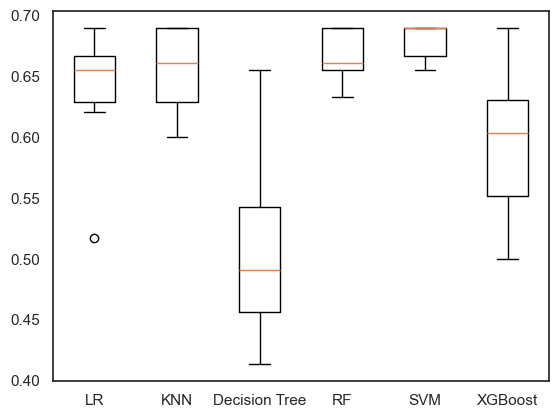

In [220]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline

# List of continuous and non-continuous variables
numeric_var = ["age", "age_of_onset", "eo_yrs_postsurg", "eo_year_surg",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information"]
column_names = numeric_var + list(set(X_train.columns) - set(numeric_var))

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Define models
models = {
    "LR": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(max_iter=2000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

results = []

# Loop through models
for model_name, model in models.items():
    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Create a stratified k-fold cross-validator
    kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

    # Cross-validate using the pipeline
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kf)

    # Append cross-validation results to the results list
    results.append(cv_results)

# Plot the results
plt.boxplot(results, labels=models.keys())
plt.show()

## Scale continuous variables

In [221]:
# Fit and transform on training and testing data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

## Null accuracy

In [222]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Create a DummyClassifier that always predicts the most frequent class
dummy_classifier = DummyClassifier(strategy='most_frequent')

# Fit the DummyClassifier on the training data
dummy_classifier.fit(X_train, y_train)

# Make predictions on the training data
y_pred_dummy = dummy_classifier.predict(X_test)

# Calculate null accuracy
null_accuracy = accuracy_score(y_test, y_pred_dummy)

print(f"Null Accuracy: {null_accuracy:.2f}")


Null Accuracy: 0.67


## ROC AND AUC

Here we calculate, the Weighted Average AUC Score:

This method computes the average of the metric weighted by the number of true instances for each class. It takes class imbalance into account, which is particularly useful if some classes are underrepresented in the data.

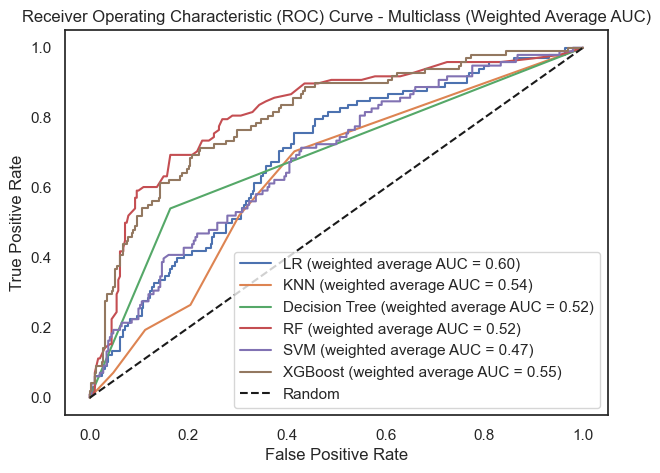

In [162]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import numpy as np

# Assuming y_train and y_test are multiclass labels
n_classes = len(np.unique(y_train))
y_train_bin = label_binarize(y_train, classes=range(n_classes))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

models = {
    "LR": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(max_iter=2000, probability=True, random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
}

plt.figure(figsize=(7, 5))

for name, model in models.items():
    # Fit the model on the training data
    # Using OneVsRestClassifier for multiclass classification
    clf = OneVsRestClassifier(model)
    clf.fit(X_train_scaled, y_train_bin)

    # Predict probabilities
    y_pred_prob = clf.predict_proba(X_test_scaled)

    # Compute the weighted average ROC AUC score
    roc_auc_weighted = roc_auc_score(y_test_bin, y_pred_prob, average='weighted', multi_class='ovr')

    # Compute and plot ROC curve for each model
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    plt.plot(fpr, tpr, label=f"{name} (weighted average AUC = {roc_auc_weighted:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve - Multiclass (Weighted Average AUC)")
plt.legend(loc="lower right")
plt.show()

## Logistic Regression

In [163]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a Logistic Regression classifier for multiclass prediction
lr = LogisticRegression(max_iter=2000, random_state=42, multi_class='auto')

# Train the classifier on the training data
lr.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = lr.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.40


### Logistic Regression Coefficients

\begin{equation}
P(Y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1 + \beta_2x_2 + \ldots + \beta_nx_n)}}
\end{equation}

* Positive Coefficient: A positive coefficient for a feature means that an increase in that feature's value is associated with an increase in the log-odds of the response variable being in the positive class.

* Negative Coefficient: A negative coefficient for a feature means that an increase in that feature's value is associated with a decrease in the log-odds of the response variable being in the positive class.

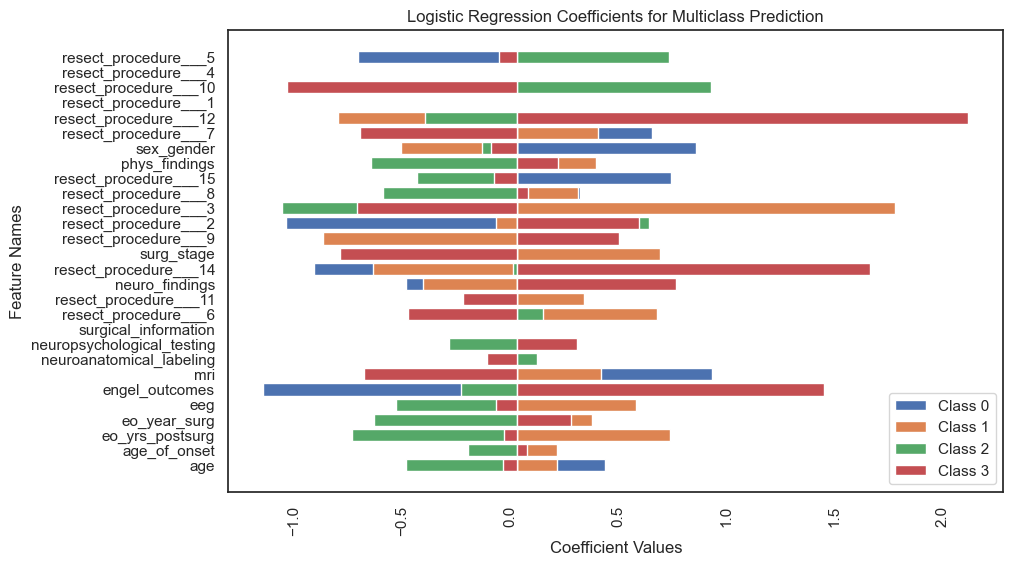

In [164]:
import numpy as np
import matplotlib.pyplot as plt

# Get the coefficients and feature names
coefficients = lr.coef_  # This will give you coefficients for each class

# Create a bar plot for each class
plt.figure(figsize=(10, 6))
for class_label in range(len(coefficients)):
    plt.barh(column_names, coefficients[class_label], label=f'Class {class_label}')
plt.xlabel('Coefficient Values')
plt.ylabel('Feature Names')
plt.title('Logistic Regression Coefficients for Multiclass Prediction')
plt.xticks(rotation=90, ha="right")
plt.legend()
plt.show()

In [165]:
# Get the intercept and coefficients
intercept = lr.intercept_[0]
coefficients = lr.coef_[0]

# Display the logistic regression equation
equation = f"P(Y=1) = 1 / (1 + e^(-({intercept:.4f} + "
for feature, coefficient in zip(numeric_var, coefficients):
    equation += f"{coefficient:.4f} * {feature} + "
equation = equation[:-2]  # Remove the trailing ' + '
equation += ")))"

print("Logistic Regression Equation:")
print(equation)

Logistic Regression Equation:
P(Y=1) = 1 / (1 + e^(-(2.2538 + 0.4040 * age + -0.0008 * age_of_onset + 0.1232 * eo_yrs_postsurg + 0.0732 * eo_year_surg + 0.1133 * eeg + -1.1751 * engel_outcomes + 0.9022 * mri + 0.0125 * neuroanatomical_labeling + -0.0584 * neuropsychological_testing + 0.0000 * surgical_information )))


## Decision Tree classifier

In [166]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create a Decision Tree Classifier for multiclass prediction
clf = DecisionTreeClassifier(max_depth=3, random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.50


In [167]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=100, cv=5, verbose=1, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", random_search.best_params_)

# Use the best model to make predictions
best_clf = random_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Evaluate the accuracy, precision, recall, and F1-score of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini'}
Accuracy: 0.41
Precision: 0.45
Recall: 0.41
F1-Score: 0.43


### Plot decision tree

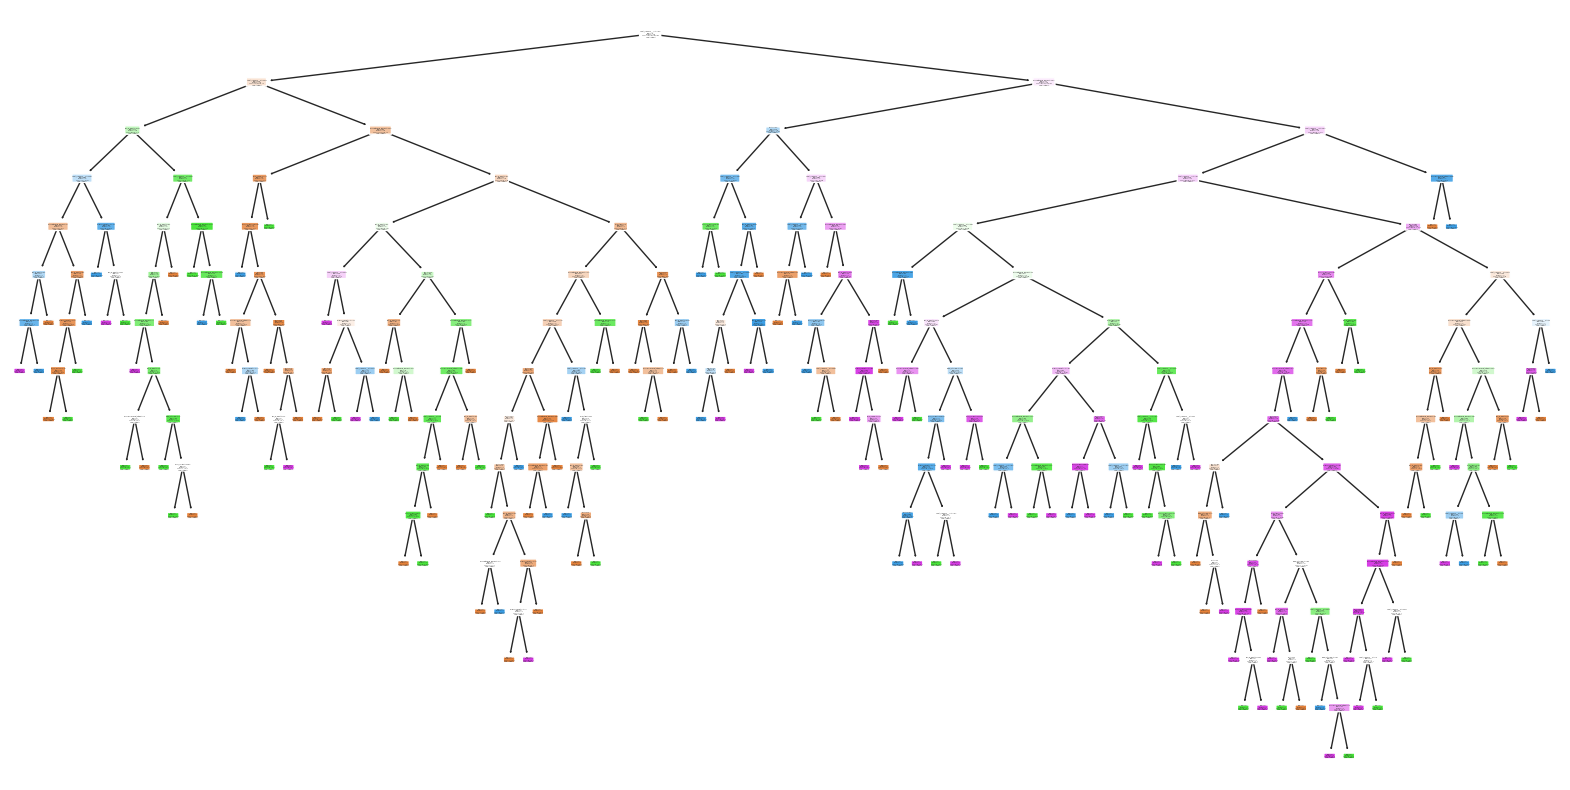

In [168]:
from sklearn.tree import plot_tree

# Define class names for your specific problem (modify as needed)
class_names = ["Class I", "Class II", "Class III", "Class IV"]

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_clf, filled=True, feature_names=column_names, class_names=class_names, rounded=True)
plt.show()


## Random Forest

In [169]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.65


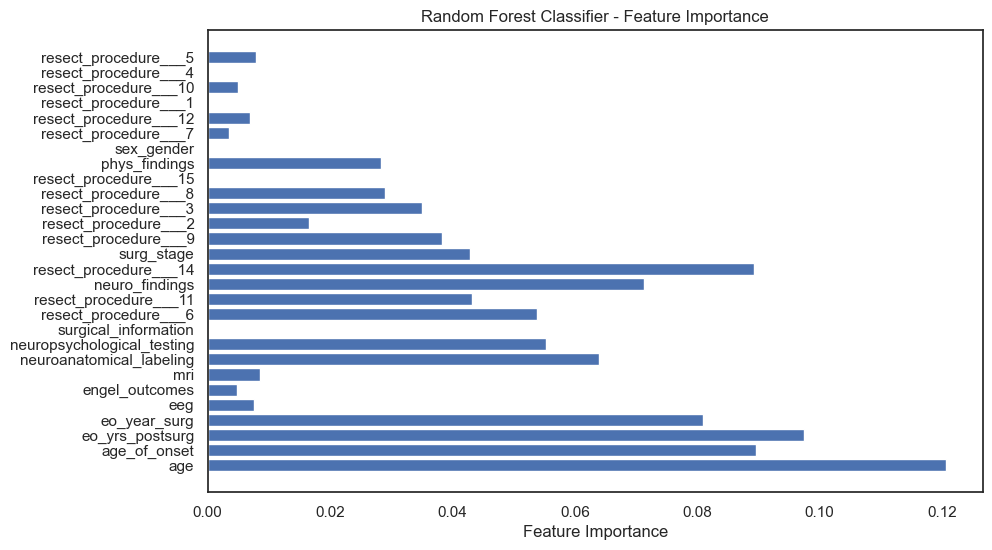

In [170]:
# Get feature importances from the trained Random Forest model
feature_importances = rf.feature_importances_

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align="center")
plt.yticks(range(len(feature_importances)), column_names)
plt.xlabel("Feature Importance")
plt.title("Random Forest Classifier - Feature Importance")
plt.show()

## Support Vector Machines (SVM)

In [171]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an SVM classifier
svc = SVC(kernel='linear', C=1, random_state=42)

# Train the classifier on the training data
svc.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = svc.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.39


Positive coefficients indicate that the corresponding features are positively correlated with the target class, while negative coefficients indicate a negative correlation.

ValueError: The number of FixedLocator locations (168), usually from a call to set_ticks, does not match the number of labels (28).

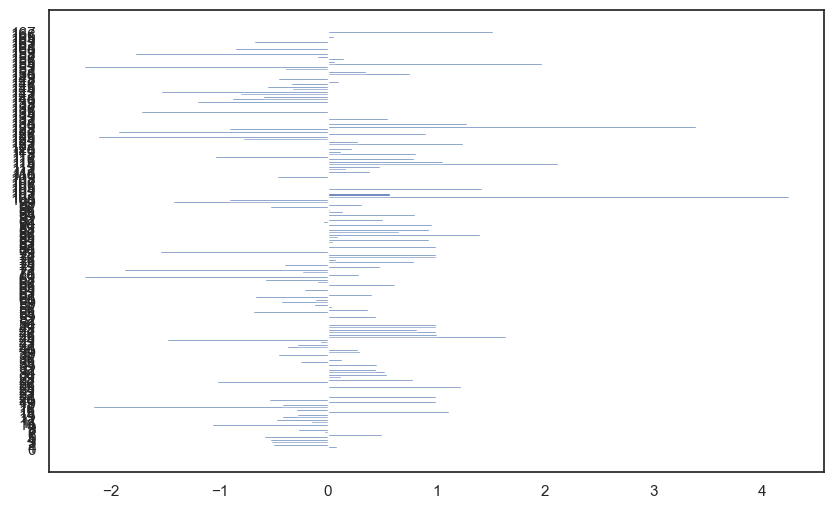

In [172]:
# Get the coefficients (weights) from the trained SVM model
coefficients = svc.coef_.flatten()

# Create a bar plot of feature coefficients
plt.figure(figsize=(10, 6))
plt.barh(range(len(coefficients)), coefficients, align="center")
plt.yticks(range(len(coefficients)), column_names)
plt.xlabel("Coefficient Value")
plt.title("SVM Classifier - Feature Coefficients")
plt.show()

In [ ]:
(X_train["engel_outcomes"]==2).sum()

1

## XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Create an XGBoost classifier for multiclass prediction
xgb = XGBClassifier(objective='multi:softmax', random_state=42)

# Train the classifier on the training data
xgb.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = xgb.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.57


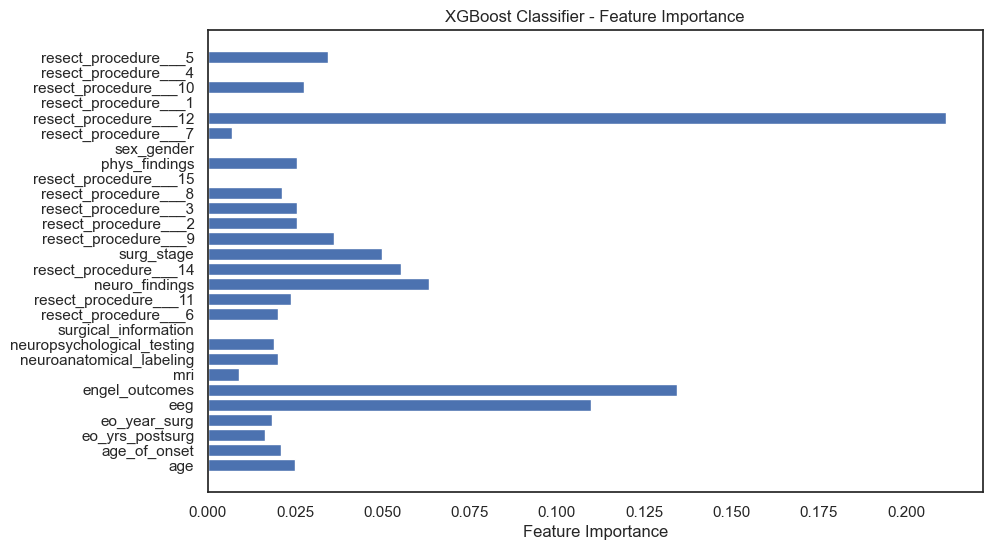

In [ ]:
# Get feature importances from the trained XGBoost model
feature_importances = xgb.feature_importances_

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align="center")
plt.yticks(range(len(feature_importances)), column_names)
plt.xlabel("Feature Importance")
plt.title("XGBoost Classifier - Feature Importance")
plt.show()

## Neural Network

In [ ]:
import tensorflow as tf

# Create a simple neural network model using Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(set(y_train)), activation='softmax')  # Output layer for multiclass classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data
model.fit(X_train_scaled, y_train, epochs=15, batch_size=64, validation_split=0.2, verbose=2)

# Make predictions on the test data
y_pred_prob = model.predict(X_test_scaled)
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Epoch 1/15
4/4 - 2s - loss: 1.4114 - accuracy: 0.0803 - val_loss: 1.3868 - val_accuracy: 0.1270 - 2s/epoch - 446ms/step
Epoch 2/15
4/4 - 0s - loss: 1.3734 - accuracy: 0.3173 - val_loss: 1.3601 - val_accuracy: 0.4762 - 56ms/epoch - 14ms/step
Epoch 3/15
4/4 - 0s - loss: 1.3468 - accuracy: 0.6225 - val_loss: 1.3363 - val_accuracy: 0.6349 - 48ms/epoch - 12ms/step
Epoch 4/15
4/4 - 0s - loss: 1.3173 - accuracy: 0.7028 - val_loss: 1.3060 - val_accuracy: 0.6508 - 49ms/epoch - 12ms/step
Epoch 5/15
4/4 - 0s - loss: 1.2800 - accuracy: 0.6988 - val_loss: 1.2652 - val_accuracy: 0.6508 - 53ms/epoch - 13ms/step
Epoch 6/15
4/4 - 0s - loss: 1.2304 - accuracy: 0.6988 - val_loss: 1.2120 - val_accuracy: 0.6508 - 52ms/epoch - 13ms/step
Epoch 7/15
4/4 - 0s - loss: 1.1711 - accuracy: 0.6988 - val_loss: 1.1520 - val_accuracy: 0.6508 - 49ms/epoch - 12ms/step
Epoch 8/15
4/4 - 0s - loss: 1.1012 - accuracy: 0.6988 - val_loss: 1.0928 - val_accuracy: 0.6508 - 52ms/epoch - 13ms/step
Epoch 9/15
4/4 - 0s - loss: 1.026

## Perform PCA

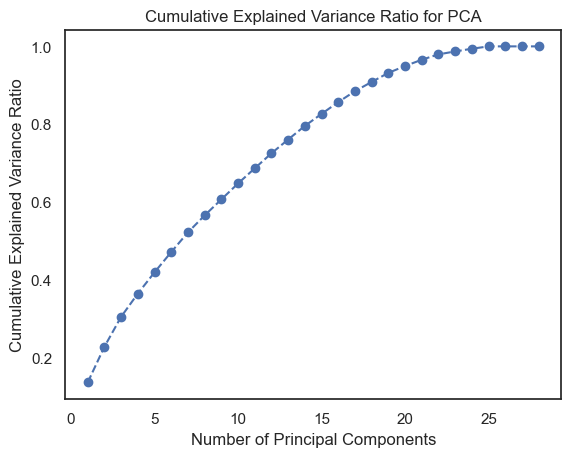

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Extract numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can use other strategies like 'median' or 'most_frequent'
numerical_features_imputed = pd.DataFrame(imputer.fit_transform(numerical_features), columns=numerical_features.columns)

# Data preprocessing (standardization)
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features_imputed)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(numerical_features_scaled)

# Plot explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio for PCA')
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

X2 = wide_df.drop(["surg_engel", "surg_engel___1", "surg_engel___2", "surg_engel___3",
                   "surg_engel___4", "engel_class1", "engel_class2", "engel_class3",
                   "engel_class4",], axis=1)
# Extract numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numerical_features, y, test_size=0.2, random_state=42)

# Impute missing values separately for training and testing sets
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Data preprocessing (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Perform PCA
pca = PCA(n_components=20)  # Choose the number of components based on your analysis
pca_result_train = pca.fit_transform(X_train_scaled)
pca_result_test = pca.transform(X_test_scaled)

# Create a Support Vector Machine
svc = SVC(kernel='linear', C=1.0, random_state=42)

# Train the classifier on the training data
svc.fit(pca_result_train, y_train)

# Make predictions on the test data
y_pred = svc.predict(pca_result_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.62


In [236]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Separate features and target
X = wide_df.drop(["surg_engel", "surg_engel___1", "surg_engel___2", "surg_engel___3",
                   "surg_engel___4", "engel_class1", "engel_class2", "engel_class3",
                   "engel_class4",], axis=1)
y = wide_df[["surg_engel___1", "surg_engel___2", "surg_engel___3", "surg_engel___4"]]

# Extract numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numerical_features, y, test_size=0.2, random_state=42)

# Impute missing values separately for training and testing sets
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Data preprocessing (standardization)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train_imputed)
#X_test = scaler.transform(X_test_imputed)

model = Sequential()
model.add(Dense(700, activation='relu', input_shape=(X_train_imputed.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(350, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(150, activation='relu'))
model.add(Dense(len(set(y_train)), activation='softmax'))  # Adjust according to your output classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data
history = model.fit(X_train_imputed, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=2)

# Evaluate the accuracy of the model
loss, accuracy = model.evaluate(X_test_imputed, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/50
4/4 - 1s - loss: 113.0330 - accuracy: 0.5301 - val_loss: 76.1779 - val_accuracy: 0.6508 - 1s/epoch - 292ms/step
Epoch 2/50
4/4 - 0s - loss: 74.9096 - accuracy: 0.4900 - val_loss: 14.7601 - val_accuracy: 0.6508 - 83ms/epoch - 21ms/step
Epoch 3/50
4/4 - 0s - loss: 50.3885 - accuracy: 0.4498 - val_loss: 24.0936 - val_accuracy: 0.6508 - 73ms/epoch - 18ms/step
Epoch 4/50
4/4 - 0s - loss: 40.4218 - accuracy: 0.5663 - val_loss: 22.3250 - val_accuracy: 0.6508 - 110ms/epoch - 27ms/step
Epoch 5/50
4/4 - 0s - loss: 32.5163 - accuracy: 0.5141 - val_loss: 9.4397 - val_accuracy: 0.6508 - 74ms/epoch - 18ms/step
Epoch 6/50
4/4 - 0s - loss: 29.4609 - accuracy: 0.4498 - val_loss: 8.2459 - val_accuracy: 0.6508 - 70ms/epoch - 18ms/step
Epoch 7/50
4/4 - 0s - loss: 26.3847 - accuracy: 0.4739 - val_loss: 10.8163 - val_accuracy: 0.6508 - 78ms/epoch - 20ms/step
Epoch 8/50
4/4 - 0s - loss: 20.3697 - accuracy: 0.5823 - val_loss: 10.0444 - val_accuracy: 0.6508 - 78ms/epoch - 20ms/step
Epoch 9/50
4/4 - 

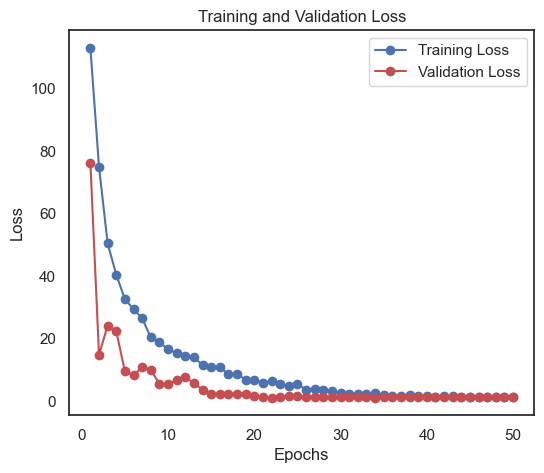

In [237]:
import matplotlib.pyplot as plt

# Extracting loss and accuracy from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(6, 5))

# Training vs Validation Loss
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

3/3 [==============================] - 0s 4ms/step


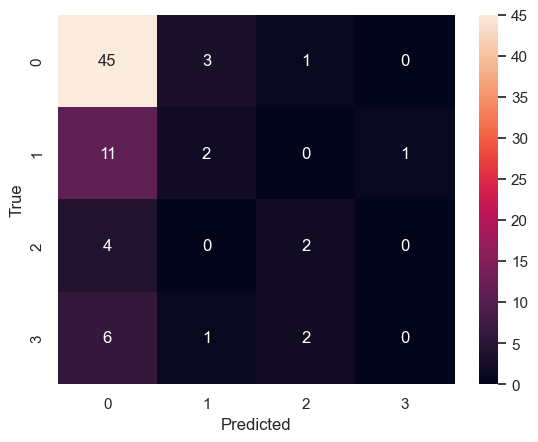

In [199]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a trained model and test data
y_pred = model.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [223]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Separate features and target
X = wide_df.drop(["surg_engel", "surg_engel___1", "surg_engel___2", "surg_engel___3",
                   "surg_engel___4", "engel_class1", "engel_class2", "engel_class3",
                   "engel_class4",], axis=1)
y = wide_df["surg_engel"] - 1

# Extract numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numerical_features, y, test_size=0.2, random_state=42)

# Impute missing values separately for training and testing sets
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Data preprocessing (standardization)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train_imputed)
#X_test = scaler.transform(X_test_imputed)

# Define a range of hyperparameters for randomized search
param_distributions = {
    'n_estimators': [300, 400, 500],
    'learning_rate': [0.005, 0.01, 0.05],
    'max_depth': [4, 5, 6],
    'subsample': [0.4, 0.5, 0.6],
    'colsample_bytree': [0.5, 0.6, 0.7]
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions,
                                   n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search to the data
random_search.fit(X_train_imputed, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
accuracy = best_model.score(X_test_imputed, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.5}
Best Score: 0.6893145161290323
Test Accuracy: 64.10%


## Print system information

In [ ]:
import session_info

session_info.show()

KeyError: 'pybind11_abseil'